# Getting notifications when a task completes

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

This notebook walks you through how to set up notifications for completion of Amazon Braket tasks through the Amazon Simple Notification Service (SNS). Active notifications may be useful in situations where a large wait time is expected, such as when a submitted task is large and takes a while to complete, or when a task is submitted to a device outside of its availability window. In such a setting, a user may not want to wait for the task to complete, and would prefer to move forward and receive an alert once the task is complete.

## The workflow

Amazon Braket tasks leverage Amazon S3 as an intermediate storage device. This allows you to leverage the built-in event architecture of S3 to generate active push notifications. All you need to do is subscribe an SMS capable endpoint (for example, an email address or a cell phone number) to an SNS Topic, and tie that SNS Topic to the S3 bucket of interest.

See the architecture diagram for a full picture of the sequence of events:

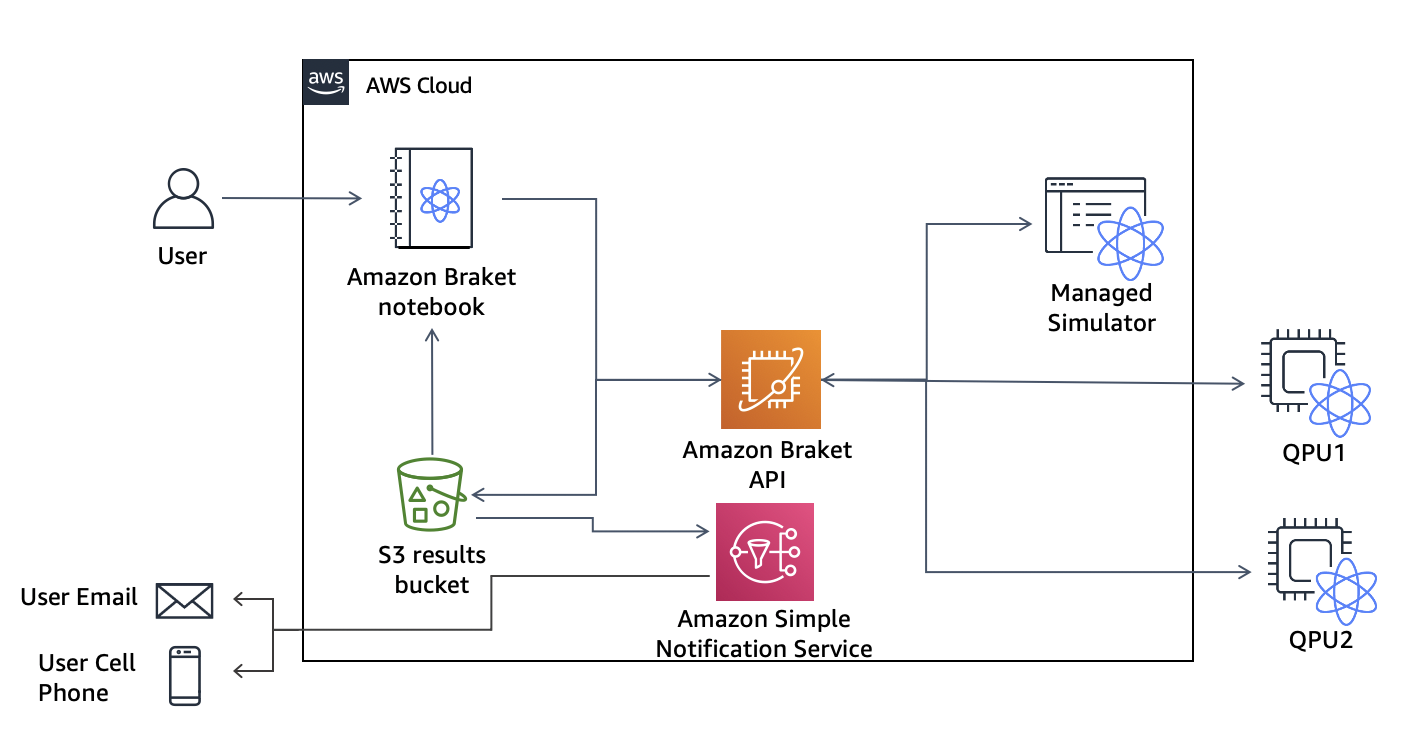

In [1]:
from IPython.display import Image
Image(filename='sns_task_notification.png')

# Instructions

### Optional Step: Create a KMS customer master key (CMK)

Security is a priority at AWS. Therefore, nearly all AWS Services integrate with AWS Key Management Service (KMS) to allow data to be encrypted in transmission and at rest. In particular, Amazon S3 and SNS are integrated with KMS. To leverage this capability, follow the quick summary provided here. First, create a custom key through the KMS console, by following these instructions:

https://docs.aws.amazon.com/kms/latest/developerguide/create-keys.html#create-symmetric-cmk

**NOTE: When creating the key, you don't need to explicitly allow any IAM users, roles, or services to have access to the key.**

After the key is created, you must edit the default Key Policy to include S3 and SNS services as Principals that can encrypt and decrypt data. Add the following permission within the "Statement" list (remember to replace the &lt;CMK ARN&gt; into the ARN of the key)
    
```        
{
    "Sid": "Allow access for S3 and SNS (as Service Principals)",
    "Effect": "Allow",
    "Principal": {
        "Service": [
            "s3.amazonaws.com",
            "sns.amazonaws.com"
        ]
    },
    "Action": [
        "kms:GenerateDataKey*",
        "kms:Decrypt"
    ],
    "Resource": "<CMK ARN>"
}
```

### Step 1: Create an Appropriate S3 Bucket

You can create an S3 bucket to receive the Amazon Braket task results. To accommodate certain IAM permissions, Amazon Braket expects your bucket name to begin with "amazon-braket-" and generally follow this naming convention:

`amazon-braket-<bucket name>`

If you don't specify the S3 location, default S3 folder, where all inputs and outputs for your tasks are saved, follows the convention `amazon-braket-<region>-<account number>`. 

### Step 2: Create an SNS Topic

Amazon Simple Notification Service (SNS) acts as the event broker that receives notifications from S3 (along a given Topic) and routes them out to any subscriber, for example, an email address. You must create that SNS Topic to serve as the central communications channel. See the following instructions:

https://docs.aws.amazon.com/sns/latest/dg/sns-tutorial-create-topic.html#create-topic-aws-console

**NOTE: If you created a CMK in the optional step, make sure you enable encryption on the SNS Topic, and select the CMK you created from the dropdown menu.**

You should already have created an S3 bucket "amazon-braket-&lt;bucket name&gt;" for this workflow. Now you must add permissions to the SNS Topic so it can receive events from the bucket. To do so, edit the Topic's "Access Policy" to paste the following permission (under the "Statement" list). Replace the contents in <>. 
    
```
{
    "Sid": "allow-S3-access",
    "Effect": "Allow",
    "Principal": {
        "AWS": "*"
    },
    "Action": "SNS:Publish",
    "Resource": "arn:aws:sns:<region>:<account_id>:<sns_topic_name>",
    "Condition": {
        "StringEquals": {
            "aws:SourceAccount": "<account_id>"
        },
        "ArnLike": {
            "aws:SourceArn": "arn:aws:s3:*:*:amazon-braket-<bucket name>"
        }
    }
}
```

### Step 3: Subscribe an endpoint to the SNS Topic

Follow the instructions here to subscribe an endpoint to an SNS Topic:

https://docs.aws.amazon.com/sns/latest/dg/sns-create-subscribe-endpoint-to-topic.html

SNS > Subscriptions > Create subscription > choose the Topic ARN from the dropdown menu > choose the protocol from the dropdown menu (SMS for cell phone number and Email for email address) > fill in the details of the endpoint

**NOTE: SNS is not a free service. Check the pricing [here](https://aws.amazon.com/sns/pricing/). Sending text messages to non-US cell phone numbers might be expensive. On the other hand, the default spending limit for SMS messages is 1.00 USD per month. You can [request](https://aws.amazon.com/premiumsupport/knowledge-center/sns-sms-spending-limit-increase/) a limit increase through the support center.**

After this step is completed, you should see the endpoint listed under the SNS > Subscriptions tab in the console. To test functionality, go to the subscribed Topic and publish a test message by choosing "Publish message". If the endpoint is subscribed properly, you will receive a message immediately, containing the message title and text you provided. If you do not receive a text, double check the instructions in this step

### Step 4: Create an S3 Event and tie it to the SNS Topic

Follow the instructions provided here to create a new S3 Event:

https://docs.aws.amazon.com/AmazonS3/latest/user-guide/enable-event-notifications.html#enable-event-notifications-how-to

Open the Amazon S3 console > choose the bucket `amazon-braket-<bucket name>` > Properties > choose Create event notification under Event notifications > Enter event name, prefix, and suffix > choose event type > choose SNS topic as the destination > select the SNS topic created in Step 2 from the dropdown menu.

**NOTE 1: AWS recommends that you filter the S3 events by prefix to prevent unnecessary notifications. For the purpose of this tutorial, you can add a prefix filter on `sns-testing/` , which is used as the destination in the following cell for Braket task outputs.**

**NOTE 2: If the SNS Topic ARN does not appear in the dropdown menu, it is likely that the appropriate permissions were not added to the Topic Access Policy - review Step 2.**

### Step 5: Test the setup with a Braket task

Now the pipeline is configured and ready to test. To test it, run the following code to kick off an Amazon Braket task. After the task state registers as "COMPLETED", within a few seconds you should receive a message stating that a file has been added to the S3 bucket. Your task is done.

In [2]:
from braket.circuits import Circuit
from braket.aws import AwsDevice

n_qubits = 10
n_shots = 100

device = AwsDevice('arn:aws:braket:::device/quantum-simulator/amazon/sv1')
# ##

def ghz_circuit(n_qubits: int) -> Circuit:
    """
    Function to return simple GHZ circuit ansatz. Assumes all qubits in range(0, n_qubits-1)
    are entangled.

    :param int n_qubits: number of qubits
    :return: Constructed GHZ circuit
    :rtype: Circuit
    """

    circuit = Circuit()                          # instantiate circuit object
    circuit.h(0)                                 # add Hadamard gate on first qubit

    for ii in range(0, n_qubits-1):
        circuit.cnot(control=ii, target=ii+1)    # apply series of CNOT gates
    return circuit


# Define circuit
ghz = ghz_circuit(n_qubits)

# Kick off single task execution
task = device.run(ghz, shots=n_shots)

In [3]:
task.state()

'QUEUED'

In [10]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 100, 'tasks': {'COMPLETED': 1}, 'execution_duration': datetime.timedelta(microseconds=112000), 'billed_execution_duration': datetime.timedelta(seconds=3)}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.004 USD
